In [19]:
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error as sk_mae, mean_squared_error as mse
import  sys, copy, pickle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
if True:
    path_to_repo = '/content/drive/My Drive/Transprecision_Computing/IJCAI/'
    from google.colab import drive
    drive.mount('/content/drive')
sys.path.insert(1,'/content/drive/My Drive/Transprecision_Computing/IJCAI/')

import torch
from torch import nn
Ten = torch.FloatTensor
iTen = torch.LongTensor

def mae(y_true, y_pred):
    """ Compute Mean Absolute Error

    This function computes MAE on the non log
    error

    Parameters
    ----------
        y_true : list(float)
            True value for
            a given sample of data
        y_pred : list(float)
            Predicted value for
            a given sample of data

    Returns
    -------
        MAE : float
            Mean Absolute Error

    """
    y_pred = np.array([10 ** -y for y in y_pred])
    y_true = np.array([10 ** -y for y in y_true])
    return np.mean(np.abs(y_pred - y_true))


def is_dominant(x, y):
    """ Checks if the configuration x is dominant over y

    Parameters
    ----------
        x : list(float)
            configuration
        y : list(float)
            configuration

    Returns
    -------
        Dominance Truth Value : bool
            True if x is dominant over y, False otherwise

    """
    n = len(x) if isinstance(x, list) else x.shape[0]
    return all([x[i] > y[i] for i in range(n)])


def couples(precision):
    """ Counts number of couples dominant dominated """
    n = len(precision)
    couples = []
    for i in range(n):
        x = np.repeat([precision[i]], n, axis=0)
        dominated_idx = np.where(np.all(x > precision, axis=1))[0]
        couples += [(i, j) for j in list(dominated_idx)]

    return couples


def violated_const(precision, error):
    """ Counts number of violated_const

        if x' is dominant on x'' -> -log10(e(x')) > -log10(e(x''))

    """
    n = len(precision)
    violated_const = [(i, j) for (i, j) in couples(precision) if error[i] < error[j]]

    return violated_const


def duplicates(error):
    """ Computes the number of duplicates in the error predicted, especially,
        sums the number of repetition of the 3 most frequent elements.

        This function is used to check the validity of the results predicted
        by the model. As observed previous experimens, high values in the
        multiplier lead to trivial prediction, i.e. for every instance the prediction
        has often the same outcome
    """
    u, c = np.unique(np.round(error, 5), return_counts=True)
    dup = list(zip(u, c))
    dup.sort(key=lambda x: x[1])
    return sum([dup[-1][1], dup[-2][1], dup[-3][1]]) / len(error)


# this procedure is used to create dataset which have a high ratio of constraint violations.
# this allows for consistent value of the regularizator at training time.
def build_dataset(benchmark, n_data, violations_ratio, seed):
    """ Builds a dataset with the desired amount of violated constraints """
    np.random.seed(seed)
    nerr = 30
    suff_label_target = 'err_ds_'
    n_violated_const = int(n_data * violations_ratio)
    labels_target = [suff_label_target + str(i) for i in range(nerr)]

    # reading dataset from csv
    data_file = 'exp_results_{}.csv'.format(benchmark)
    df = pd.read_csv(path_to_repo + 'data/' + data_file, sep=';')
    n_var = len(list(df.filter(regex='var_*')))  # number of variable in the configuration
    # error is capped at 0.95
    for _label_target in labels_target:
        df[_label_target] = [0.95 if x > 0.95 else x for x in df[_label_target]]
        df[_label_target] = [sys.float_info.min if 0 == x else -np.log10(x) for x in df[_label_target]]
    # preprocessing
    scaler = preprocessing.MinMaxScaler()
    X = scaler.fit_transform(df.iloc[:, 0:n_var])
    y = np.mean(scaler.fit_transform(df[labels_target]), axis=1, dtype='float32').reshape((-1, 1))
    # inject constraint violations
    dataset_violated_const = violated_const(X, y)
    if len(dataset_violated_const) < n_violated_const:
        # the number of violated constraints we want to inject in the dataset exceed the number
        # of violated constraints available in the dataset
        raise ValueError('The desired number of injected constrait violations is not available')
    idx = set()  # set containing indexes of samples in the final dataset used for the training
    idx_control = set()  # set used to count the number of violated constraints used
    while len(idx) != n_violated_const and len(idx_control) < len(dataset_violated_const):
        k = np.random.randint(len(dataset_violated_const))
        idx_control.add(k)
        (i, j) = dataset_violated_const[k]
        idx.add(i)
        idx.add(j)
    while len(idx) < n_data:
        idx.add(np.random.randint(len(X)))
    idx = list(idx)
    return X[idx], y[idx]




class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
        idim = params['i_dim']
        odim = params['o_dim']
        hdim = params['h_dim']
        self._nlayers = params['n_layers']
        self._af = nn.ReLU
        self._of = nn.Linear

        self.i_layer = nn.Sequential(
            nn.Linear(idim, hdim),
            self._af(inplace=True))

        layers = []
        for i in range(self._nlayers-1):
            layers.append(nn.Linear(hdim, hdim))
            layers.append(self._af(inplace=True))
        self.h_layers = nn.Sequential(*layers)

        self.o_layer = nn.Sequential(
            nn.Linear(hdim, odim))

    def forward(self, x):
        o = self.i_layer(x)
        o = self.h_layers(o)
        return self.o_layer(o)

    def predict(self, x):
        pred = self.forward(x)
        return pred.detach().numpy()


class DataIterator(object):
    def __init__(self, dataset, batchsize, device):
        # object reference (a list of tuples of lists)
        self._dataset = dataset
        self._len = len(dataset[0])
        # keep track of current index
        self._index = 0
        # the batch size
        self._batchsize = batchsize
        self._device = device

    def __next__(self):
        ''''Returns the next value from object's lists '''

        n = min(self._len, self._index + self._batchsize)
        if self._index < self._len:
            x = self._dataset[0][self._index:n]
            y = self._dataset[1][self._index:n]
            self._index = n
            return Ten(x).to(self._device), Ten(y).to(self._device)

        # End of Iteration
        raise StopIteration


class Dataset(object):

    def __init__(self, params, mode, device):
        assert mode in ['train', 'test', 'valid']
        np.random.seed(params['seed'])
        #self._const = 0  # constrain counter
        self._device = device
        self._n_data = params['n_data']
        self._benchmark = params['benchmark']
        self._batchsize = params['batch_size']
        self._violated_const_ratio = params['violated_const_ratio'] if mode == 'train' else 0
        # builds ad hoc dataset, the number of violated_ constraints can be tuned
        (X, y) =  build_dataset(self._benchmark, self._n_data, self._violated_const_ratio, params['seed'])
        #self._const += len(violated_const(X, y))
        self._n_var = len(X[0])
        # select data
        indices = self._get_indexes(params, self._n_data, mode, params['seed'])
        X, y = X[indices], y[indices]
        self._dataset = tuple([X, y])

    @property
    def n_var(self):
        return self._n_var

    #@property
    #def const(self):
    #    return self._const

    def _get_indexes(self, params, n_data, mode, seed):
        indices = np.arange(n_data)
        np.random.seed(seed)
        np.random.shuffle(indices)
        split_size = dict()
        modeidx = {'train': 0, 'test': 1, 'valid': 2}
        for m in ['train', 'test', 'valid']:
            split_size[m] = int(params['split'][modeidx[m]] * n_data)
        if mode == 'train':
            indices = indices[0:split_size['train']]
        elif mode == 'test':
            indices = indices[split_size['train']:split_size['test'] + split_size['train']]
        else:
            indices = indices[split_size['train'] + split_size['test']:-1]
        return indices

    def __iter__(self):
        return DataIterator(self._dataset, self._batchsize, self._device)



class AbstractAgent():
    def __init__(self, params, d_train, d_test, d_val, start_point_seed=0):
        # CUDA for PyTorch
        use_cuda = torch.cuda.is_available()
        self._device = torch.device("cuda:0" if use_cuda else "cpu")

        self._train_data = d_train
        self._test_data = d_test
        self._valid_data = d_val
        self.start_point_seed = start_point_seed
        #torch.manual_seed(start_point_seed)
        self._nepochs = params['epochs']
        self._batchsize = params['batch_size']

        #self._model = None
        self._optimizer = None
        self._loss = None
        self.logs = []
        self.verbose = False

    def _init_model(self):

        torch.manual_seed(self.start_point_seed)
        net_par = {'i_dim': self._train_data.n_var,
                   'o_dim': 1,
                   'h_dim': 10,
                   'n_layers': 1}

        self._model = Net(net_par)
        self._optimizers = torch.optim.Adam(self._model.parameters(), lr=0.001)
        self._LR_multiplier_list = []
        self.logs = []


    def train(self):
        for epoch in range(self._nepochs):
            for (x, y) in self._train_data:
                y_pred = self.predict(x)
                loss = self.compute_loss(y_pred, y, x)
                self.propagate_loss(loss)
            self.print_report(epoch)
            self.validation_step(epoch)

    def opt_lr_rate(self):
        '''
        Optimize the Lagrangian step size. Should we run only 1 time for data of same violation ratio, 
        and  same number of training samples,

        :return: set class object with optimal logs, and optimal model with optimal lr 
        '''
        model_list = []
        lr_list = [1e-3, 5 * 1e-3, 1e-2, 5 * 1e-2, 1e-1]
        val_mae_list = []
        val_vc_list = []
        model_list = []
        logs_list = []
        _LR_multiplier_list_list = []
        for lr in lr_list:
            self._LR_rate = lr
            self._init_model()
            self.train(options = {'mult_fixed':False})
            val_mae_list.append(copy.deepcopy(self.logs[-1][0]))  # use deep copy for safety reason
            val_vc_list.append(copy.deepcopy(self.logs[-1][2]))
            model_list.append(copy.deepcopy(self._model))
            logs_list.append(copy.deepcopy(self.logs))
            _LR_multiplier_list_list.append(copy.deepcopy(self._LR_multiplier_list))

        self.model_list = copy.deepcopy(model_list)
        self.val_mae_list = copy.deepcopy(val_mae_list)
        self.val_vc_list = copy.deepcopy(val_vc_list)

        val_mae_list = [(x - min(val_mae_list)) / float(max(val_mae_list)- min(val_mae_list)) for x in val_mae_list]
        if max(val_vc_list)>0:
          try:
            val_vc_list = [(x - min(val_vc_list)) / float(max(val_vc_list) - min(val_vc_list)) for x in val_vc_list]
          except:
            print(val_vc_list)  
        metric_list = np.asarray(val_mae_list) + np.asarray(val_vc_list)

        best_index = [idx for idx in range(5) if metric_list[idx] == np.min(metric_list)][0]

        self._model = model_list[best_index]
        self.logs = logs_list[best_index]
        if len(self.logs)>150:
          for i in range(5):
            print('len of i-th ={} log is = {}'.format(i, len(logs_list[i])))
        print('best log has len = {}'.format(len(logs_list[best_index])))
        self._LR_rate = lr_list[best_index]
        self.logs_list = logs_list
        self._LR_multiplier_list_list = _LR_multiplier_list_list
        self._LR_multiplier_list = _LR_multiplier_list_list[best_index]


    def predict(self, x):
        return self._model(x)

    def propagate_loss(self, loss):
        self._optimizer.zero_grad()
        loss.backward()
        self._optimizer.step()

    def validation_step(self, epoch):
        #mae_res = list()
        violated_const_model = 0
        violated_const_dataset = 0
        (X, y) = self._valid_data._dataset
        y_pred = self._model.predict(Ten(X))
        val_mae = mae(y, y_pred)
        violated_const_dataset += len(violated_const(X, y))
        violated_pairs = violated_const(X, y_pred)
        violated_const_model += len(violated_pairs)

        y_pred = copy.deepcopy( np.array([10 ** -t for t in y_pred]))
        y_true = copy.deepcopy( np.array([10 ** -t for t in y]))

        val_rmse = np.sqrt( mse(y_true, y_pred))
        y_diff = np.abs(y_true - y_pred)
        sum_mag_viol = np.sum([abs( y_pred[i] -y_pred[j]) for (i,j) in violated_pairs]  )
        median_ae = np.median(y_diff)
        mean_ae = np.mean(y_diff)

        if self.verbose:
            print(f"epoch: {epoch}, "
                  f"MAE: {val_mae}, "
                  f"Violated constraints dataset: {violated_const_dataset}, "
                  f"Violated constraints model: {violated_const_model}")

        self.logs.append([val_mae, violated_const_dataset,  violated_const_model, median_ae, mean_ae, val_rmse, sum_mag_viol])
    def print_report(self, epoch):
        pass

    def test(self):
        #mae_list = list()
        violated_const_dataset = 0
        violated_const_model = 0
        (X, y) = self._test_data._dataset
        y_pred = self._model.predict(Ten(X))

        test_mae = mae(y, y_pred)
        violated_const_dataset += len(violated_const(X, y))
        violated_pairs = violated_const(X, y_pred)
        violated_const_model += len(violated_pairs)

        y_pred = copy.deepcopy(np.array([10 ** -t for t in y_pred]))
        y_true = copy.deepcopy(np.array([10 ** -t for t in y]))

        y_diff = np.abs(y_true - y_pred)
        median_ae = np.median(y_diff)
        mean_ae = np.mean(y_diff)
        rmse_ = np.sqrt(mse(y, y_pred))
        sum_mag_viol = np.sum([abs(y_pred[i] - y_pred[j]) for (i, j) in violated_pairs])

        #print(f"Test precision: {test_mae}, "
        #      f"Violated constraints Dataset: {violated_const_dataset}, "
       #       f"Violated constraints Model: {violated_const_model}, "
        #      f"Duplicates: {duplicates(y_pred)}")
        self.y_true  = y_true
        self.y_pred = y_pred
        self.violated_pairs = violated_pairs
        return (test_mae, violated_const_model, violated_const_dataset, median_ae, mean_ae, rmse_, sum_mag_viol )
        #return (test_mae, violated_const_model, median_ae, mean_ae, rmse_)


    def build_kwb_matrix(self, data):
        """ Build matrix containg dominance informatins

        Every couple (dominant, dominated) is tracked in the matrix.
        Each row represents a couple, while each column a training sample.
        Dominand samples are marked with -1, while the dominated with 1.
        """
        all_couples = couples(data.tolist())
        n = max(1, len(all_couples))
        kwb_matrix = np.zeros((n, len(data)))
        for (k, (i, j)) in enumerate(all_couples):
            kwb_matrix[k, i] = -1
            kwb_matrix[k, j] = 1
        return Ten(kwb_matrix.T)

    def compute_loss(self, y_pred, y, x=None):
        pass

    def plot(self):
        pass


class Regressor(AbstractAgent):
    def __init__(self, params, d_train, d_test, d_val, start_point_seed):
        super(Regressor, self).__init__(params,d_train, d_test, d_val,  start_point_seed)
        #self._train_data = d_train
        #net_par = {'i_dim': self._train_data.n_var,
        #           'o_dim': 1,
        #           'h_dim': 10,
         #          'n_layers': 1}
        #torch.manual_seed(start_point_seed)
        #self._model = Net(net_par)
        # Optimizers, for each dataset partition
        #self._optimizers = torch.optim.Adam(self._model.parameters(), lr=0.001)
        # Loss functions for each dataset partition
        self._loss = nn.MSELoss()

    def train(self):
        super()._init_model()

        for epoch in range(self._nepochs):
            for (x, y) in self._train_data:
                y_pred = self.predict(x)
                loss = self.compute_loss(y_pred, y, x)
                self.propagate_loss(loss)
            self.validation_step(epoch)

    ''' Override the compute_loss method in AbstractAgent class'''

    def compute_loss(self, y_pred, y, x=None):
        loss = self._loss(y_pred, y)
        return loss

    ''' Override the propoagate_loss method in AbstractAgent class'''

    def propagate_loss(self, loss):
        self._optimizers.zero_grad()
        loss.backward(retain_graph=True)
        self._optimizers.step()

    ''' Override predict method in AbstractAgent class'''

    def predict(self, x):
        # Predict on each data partition
        y_pred = self._model(x)
        return y_pred


class SBRregressor(AbstractAgent):
    def __init__(self, params, d_train, d_test, d_val, start_point_seed):
        super(SBRregressor, self).__init__(params, d_train, d_test, d_val, start_point_seed)

        #self._train_data = d_train
        #net_par = {'i_dim': self._train_data.n_var,
        #           'o_dim': 1,
        #           'h_dim': 10,
         #          'n_layers': 1}

        #torch.manual_seed(start_point_seed)
        #self._model = Net(net_par)

        # Optimizers, for each dataset partition
        #self._optimizers = torch.optim.Adam(self._model.parameters(), lr=0.001)
        # Loss functions for each dataset partition
        self._loss = nn.MSELoss()
        self._const_avg_batch = 0
        self.count_const()
        self._LR_rate = None

        self._violations_epoch = []
        self._LR_multiplier_list = []



    def count_const(self):
        const_batch = []
        for (x, y) in self._train_data:
            n = max(1, len(couples(x.tolist())))
            const_batch.append(n)
        self.const_avg_batch = int(np.mean(np.array(const_batch)))

    # @property
    def const_avg_batch(self):
        return self.const_avg_batch

    def train(self, options):

        super()._init_model()

        if options['mult_fixed']:
            self._LR_multiplier = 1
        else:
            self._LR_multiplier = 0

        for epoch in range(self._nepochs):
            violations_epoch = []
            for (x, y) in self._train_data:
                M = self.build_kwb_matrix(x)
                y_pred = self.predict(x)
                loss, violation = self.compute_loss(M, y_pred, y, x)
                self.propagate_loss(loss)
                violations_epoch.append(violation)
            if not options['mult_fixed']:
                self.update_LR_multipliers(violations_epoch)
            self.print_report(epoch)
            self.validation_step(epoch)


    ''' Override the compute_loss method in AbstractAgent class'''

    def compute_loss(self, M, y_pred, y, x=None):
        loss = self._loss(y_pred, y)
        # g(x') - g(x'') where g(x'') is dominant over g(x'), hence should be have grater value,
        # (N.B. we are considering the -log10 of the error otherwise it would be g(x'') - g(x')
        rules = torch.mm(torch.transpose(M, 0, 1), y_pred)
        # filter only the positive values (violations), therefore the violations to the constraint
        v = torch.sum(torch.max(Ten(np.zeros(rules.size()[0])), torch.transpose(rules, 0, 1)))
        loss += self._LR_multiplier * v

        return loss, v

    ''' Override the propoagate_loss method in AbstractAgent class'''

    def propagate_loss(self, loss):
        self._optimizers.zero_grad()
        loss.backward(retain_graph=True)
        self._optimizers.step()

    ''' Override predict method in AbstractAgent class'''

    def predict(self, x):
        # Predict on each data partition
        y_pred = self._model(x)
        return y_pred

    ''' Update the Lagrangian Multipliers associated to the constraint violations'''

    def update_LR_multipliers(self, violations):
        self._LR_multiplier = self._LR_multiplier + (self._LR_rate * torch.sum(Ten(violations)))

    def print_report(self, epoch):
        self._LR_multiplier_list.append(copy.deepcopy(self._LR_multiplier))
        pass
        #print('\t LR mult:', self._LR_multiplier)


class SBRregressor2(AbstractAgent):
    def __init__(self, params, d_train, d_test, d_val, start_point_seed):
        super(SBRregressor2, self).__init__(params, d_train, d_test, d_val, start_point_seed)

       
        self._loss = nn.MSELoss()
        self._LR_rate =  None
        self._violations_epoch = []
        self.const_avg_batch = 0
        self._LR_multiplier_list = []


    def initialize_LR_multipliers(self, options):
        self._LR_multipliers = []
        const_batch = []
        for (x, y) in self._train_data:
            n = max(1, len(couples(x.tolist())))
            const_batch.append(n)
            if options['mult_fixed']:
                # all Lagrangian multipliers set to be one, and will not be updated during optimization
                self._LR_multipliers.append(np.ones(n))
            else:
                self._LR_multipliers.append(np.zeros(n))
        self.const_avg_batch = int(np.mean(np.array(const_batch)))
        self._LR_multipliers = np.concatenate(self._LR_multipliers)

    # @property
    def const_avg_batch(self):
        return self.const_avg_batch()

    def train(self, options):

        super()._init_model()

        self.initialize_LR_multipliers(options)

        for epoch in range(self._nepochs):
            violations_epoch = []
            offset = 0
            for (x, y) in self._train_data:
                M = self.build_kwb_matrix(x)
                y_pred = self.predict(x)
                loss, violations = self.compute_loss(M, offset, y_pred, y, x)
                self.propagate_loss(loss)
                violations_epoch += violations
                offset += len(violations)
            if not options['mult_fixed']:
                self.update_LR_multipliers(violations_epoch)

            self.validation_step(epoch)
            self.print_report(epoch)

    ''' Override the compute_loss method in AbstractAgent class'''

    def compute_loss(self, M, offset, y_pred, y, x=None):
        loss = self._loss(y_pred, y)
        # g(x') - g(x'') where g(x'') is dominant over g(x'), hence should be have grater value,
        # (N.B. we are considering the -log10 of the error otherwise it would be g(x'') - g(x')
        rules = torch.mm(torch.transpose(M, 0, 1), y_pred)
        # filter only the positive values (violations), therefore the violations to the constraint
        rules = torch.max(Ten(np.zeros(rules.size()[0])), torch.transpose(rules, 0, 1))[0]
        # LR * max(0, g(x') - g(x''))
        lr_mults = Ten([self._LR_multipliers[offset + i] for i in range(len(rules))])
        loss += torch.sum(lr_mults * rules)
        # The below code seems  a bug, ignoring the contribution of violated constraints during optimization
        #
        #loss += torch.sum(Ten([self._LR_multipliers[offset + i] * rules[i] for i in range(len(rules))]))
        violations = [x.item() for x in rules]

        return loss, violations

    ''' Override the propagate_loss method in AbstractAgent class'''

    def propagate_loss(self, loss):
        self._optimizers.zero_grad()
        loss.backward(retain_graph=True)
        self._optimizers.step()

    ''' Override predict method in AbstractAgent class'''

    def predict(self, x):
        # Predict on each data partition
        y_pred = self._model(x)
        return y_pred

    ''' Update the Lagrangian Multipliers associated to the constraint violations'''

    def update_LR_multipliers(self, violations):
        for i in range(len(violations)):
            self._LR_multipliers[i] = self._LR_multipliers[i] + (self._LR_rate * violations[i])

    def print_report(self, epoch):
        self._LR_multiplier_list.append(copy.deepcopy(self._LR_multipliers))
        # a single element contains a vector of lambda_{i,j} at epoch time t
        pass

        #print('\t LR mult:', self._LR_multipliers)
        #print('\t AVG LR mult:', np.sum(self._LR_multipliers))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Process Data**

In [20]:
benchmark = 'convolution'
violated_const_ratio = 0.5
test_seed = 0
start_point_seed = 2
filename = str(benchmark) + '_test_seed_{}'.format(test_seed)+\
                    "_vconst" + str(violated_const_ratio) + '_start_point_seed_'+ str( start_point_seed) +'.pkl'

file_handle = open(path_to_repo + 'results/' +filename, 'rb')
res = pickle.load(file_handle)
print(res.keys())

dict_keys(['test_seed', 'd_test', 200, 400, 600, 800, 1000])


In [0]:

train_size_list = [200, 400, 600, 800, 1000]
result_list = []
for model in ['model_1_perf', 'model_2_1_perf', 'model_2_perf', 'model_3_perf', 'dump_model_perf']:
  res_pd = pd.DataFrame(data = train_size_list, columns = ['#_train_samples'])
  mae_train_size_list = []
  vc_train_size_list = []
  sum_mag_train_size_list = []
  for train_size in [200, 400, 600, 800, 1000]:
    mae_train_size_list.append( np.mean([res[train_size][i][model][0] for i in range(10)]))
    vc_train_size_list.append( np.mean([res[train_size][i][model][1] for i in range(10)]))
    sum_mag_train_size_list.append(np.mean([res[train_size][i][model][-1] for i in range(10)]) )
  res_pd['MAE_{}'.format(model)] =   mae_train_size_list
  res_pd['VC_{}'.format(model)] =   vc_train_size_list
  res_pd['Sum_Magnitude_Violated_{}'.format(model)] =   sum_mag_train_size_list
  result_list.append(copy.deepcopy(res_pd))


In [0]:
from functools import reduce
mux = pd.MultiIndex.from_product([['model_1','model_2_1','model_2','model_3','dump_model'], ['MAE','VC','SMVC']])
df_final = reduce(lambda left,right: pd.merge(left,right,on='#_train_samples'), result_list).round(4)
df_final.head(20)

temp_pd = df_final[df_final.columns.tolist()[1:]] 
temp_pd.columns =  mux

In [0]:
temp_pd['num_samples'] = df_final['#_train_samples']
cols = list(temp_pd.columns)
cols = [cols[-1]] + cols[:-1]
temp_pd= temp_pd[cols]


In [24]:
temp_pd.head(4)

num_samples model_1              model_2_1  ... model_3         dump_model          
                  MAE   VC    SMVC       MAE  ...      VC    SMVC        MAE   VC SMVC
0         200  0.1247  0.0  0.0000    0.1627  ...     0.0  0.0000     0.1704  0.0  0.0
1         400  0.1144  0.0  0.0000    0.1593  ...     0.0  0.0000     0.1700  0.0  0.0
2         600  0.1103  1.4  0.0149    0.1579  ...     1.3  0.0153     0.1699  0.0  0.0
3         800  0.1061  2.7  0.0264    0.1515  ...     2.7  0.0257     0.1698  0.0  0.0

[4 rows x 16 columns]

In [25]:
res[200][0]['model_1'].logs[-1]

[0.11533561, 0, 0, 0.09731707, 0.11533561, 0.14203094, 0.0]

In [27]:
res[200][0]['model_3']._LR_rate

0.001

In [0]:
print(temp_pd.to_latex(index = False))

\begin{tabular}{rrrrrrrrrrrrrrrr}
\toprule
num\_samples & \multicolumn{3}{l}{model\_1} & \multicolumn{3}{l}{model\_2\_1} & \multicolumn{3}{l}{model\_2} & \multicolumn{3}{l}{model\_3} & \multicolumn{3}{l}{dump\_model} \\
            &     MAE &   VC &    SMVC &       MAE &    VC &    SMVC &     MAE &    VC &    SMVC &     MAE &   VC &    SMVC &        MAE &   VC & SMVC \\
\midrule
        200 &  0.1902 &  9.6 &  0.2229 &    0.1919 &  35.8 &  0.4748 &  0.1924 &  16.0 &  0.2028 &  0.1883 &  7.4 &  0.1872 &     0.2156 &  0.0 &  0.0 \\
        400 &  0.1765 &  4.5 &  0.0804 &    0.1999 &  19.4 &  0.2149 &  0.1946 &  12.3 &  0.1887 &  0.1763 &  2.6 &  0.0369 &     0.2153 &  0.0 &  0.0 \\
        600 &  0.1687 &  2.5 &  0.0397 &    0.2022 &   9.1 &  0.0683 &  0.1902 &   6.2 &  0.0864 &  0.1723 &  1.7 &  0.0224 &     0.2151 &  0.0 &  0.0 \\
        800 &  0.1672 &  3.0 &  0.0600 &    0.2007 &   8.5 &  0.0746 &  0.1874 &   3.6 &  0.0565 &  0.1704 &  0.6 &  0.0131 &     0.2149 &  0.0 &  0.0 \\
 

In [0]:
for train_size in  [200, 400, 600, 800, 1000]:
  for i in range(10):
    if len(res[train_size][i]['model_3'].logs) > 150:
      print(train_size, i)

In [0]:
all_pd_dict = {}
for train_size in [200, 400, 600, 800, 1000]:
  pd_list = []
  for i in range(10):
    m1_mae_arr = np.asarray(  [x[-1] for x in res[train_size][i]['model_1'].logs]) 
    m_21_mae_arr = np.asarray( [x[-1] for x in res[train_size][i]['model_2_1'].logs]) 
    m2_mae_arr = np.asarray( [x[-1] for x in res[train_size][i]['model_2'].logs[:150]]) 
    m3_mae_arr = np.asarray( [x[-1] for x in res[train_size][i]['model_3'].logs[:150]]) 
  
    sub_pd = pd.DataFrame(data ={'m1':m1_mae_arr , 'm21':m_21_mae_arr, 'm2':m2_mae_arr ,'m3':m3_mae_arr,
                                 'iter':range(150)})
    pd_list.append(copy.deepcopy(sub_pd)) 
  temp_pd = pd.concat(pd_list)
  all_pd_dict[train_size] = copy.deepcopy(temp_pd) 

all_pd_dict_1 = {}
for train_size in [200, 400, 600, 800, 1000]:
  pd_list = []
  for i in range(10):
    m1_mae_arr = np.asarray(  [x[0] for x in res[train_size][i]['model_1'].logs]) 
    m_21_mae_arr = np.asarray( [x[0] for x in res[train_size][i]['model_2_1'].logs]) 
    m2_mae_arr = np.asarray( [x[0] for x in res[train_size][i]['model_2'].logs[:150]]) 
    m3_mae_arr = np.asarray( [x[0] for x in res[train_size][i]['model_3'].logs[:150]]) 
  
    sub_pd = pd.DataFrame(data ={'m1':m1_mae_arr , 'm21':m_21_mae_arr, 'm2':m2_mae_arr ,'m3':m3_mae_arr,
                                 'iter':range(150)})
    pd_list.append(copy.deepcopy(sub_pd)) 
  temp_pd = pd.concat(pd_list)
  all_pd_dict_1[train_size] = copy.deepcopy(temp_pd)    

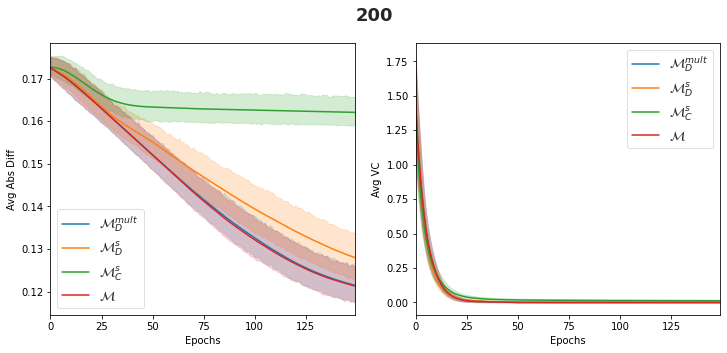

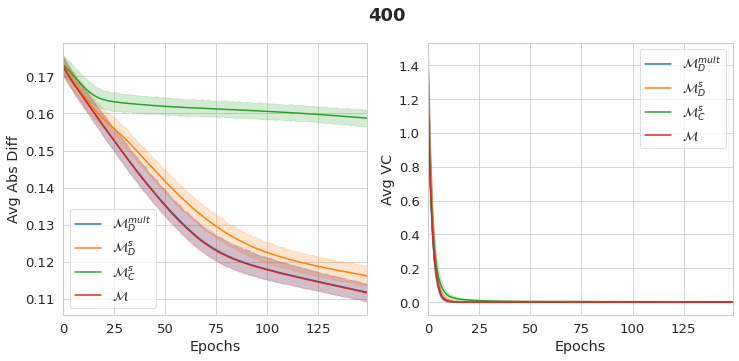

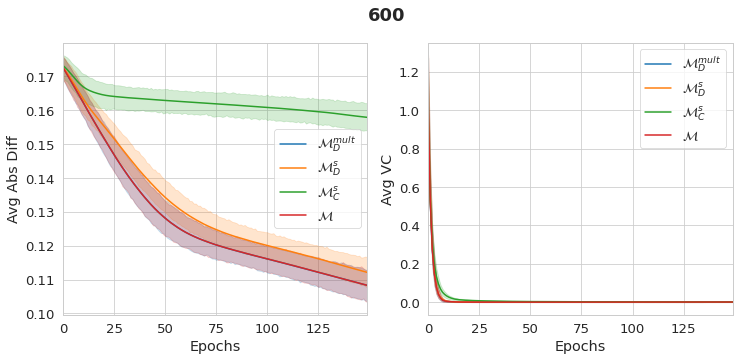

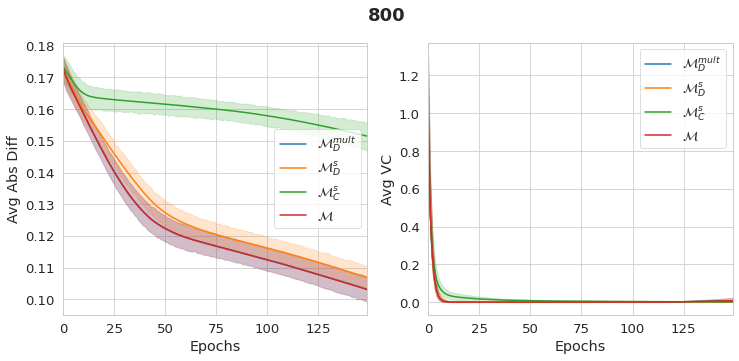

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
for name in [200, 400, 600, 800, 1000]:
  f, (ax1, ax2) = plt.subplots(figsize = (12, 5), ncols=2, sharex=True)
  #ax.set_xscale("log")
  ax1.margins(x=0)
  sns.set_style("whitegrid")
  sns.set_context('paper', font_scale=1.5, rc = {'lines.linewidth': 1.5, 'lines.markersize': 0.5})
  f = sns.lineplot(data=all_pd_dict_1[name], x='iter', y='m3', label =r'$\mathcal{M}^{mult}_D$', ax = ax1)
  f = sns.lineplot(data=all_pd_dict_1[name], x='iter', y='m2', label =r'$\mathcal{M}^s_D$', ax = ax1)
  f = sns.lineplot(data=all_pd_dict_1[name], x='iter', y='m21', label =r'$\mathcal{M}^s_{C}$', ax = ax1)
  f = sns.lineplot(data=all_pd_dict_1[name], x='iter', y='m1', label =r'$\mathcal{M}$', ax = ax1)

  f.set(xlabel='Epochs', ylabel='Avg Abs Diff')


  #f, ax = plt.subplots(figsize=(6,5 ))
  #ax.set_xscale("log")
  ax2.margins(x=0)
  sns.set_style("whitegrid")
  sns.set_context('paper', font_scale=1.5, rc = {'lines.linewidth': 1.5, 'lines.markersize': 0.5})
  f = sns.lineplot(data=all_pd_dict[name], x='iter', y='m3', label =r'$\mathcal{M}^{mult}_D$', ax = ax2)
  f = sns.lineplot(data=all_pd_dict[name], x='iter', y='m2', label =r'$\mathcal{M}^s_D$', ax = ax2)
  f = sns.lineplot(data=all_pd_dict[name], x='iter', y='m21', label =r'$\mathcal{M}^s_{C}$', ax = ax2)
  f = sns.lineplot(data=all_pd_dict[name], x='iter', y='m1', label =r'$\mathcal{M}$', ax = ax2)

  f.set(xlabel='Epochs', ylabel='Avg VC')
  plt.suptitle(name, fontsize = 18, fontweight ='bold')
  f.legend()
  plt.savefig(benchmark+ str(name)+ '.pdf')

  plt.show()
# f.legend_.remove()
#plt.savefig(data_path + topo + '_agt' + str(n_agt) + '_d' + str(dom) + '.pdf')